<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/lstm/TX_TimeSeriesLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

This colab finds the possible 'New Cases' in some counties in Texas 

# Mount Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [12]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021'

 CA_CovidDataJan10.csv
 CA_GoogleMobilityDataJan10.csv
 CA_SocialDistancingDataJan10.csv
 computed_CA_mobility_data.csv
 data-mask_for_all.csv
 election_results_2021.csv
 maryland_inertia_data_allstates_Jan11.csv
 maryland_inertia_raw_dec28_2020.csv
 Mask_Rule_Jan10.csv
 NY_CovidDataJan10.csv
 NY_GoogleMobilityDataJan10.csv
 NY_SocialDistancingDataJan10.csv
'Policy_Map_(Sized)_Full_Data_data.csv'
 TX_alldatasets_Jan11.csv
 TX_CovidDataJan10.csv
 TX_GoogleMobilityDataJan10.csv
 TX_SocialDistancingDataJan10.csv


In [75]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error,precision_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


# Load combined data for TX

In [14]:
TX_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/TX_alldatasets_Jan11.csv',low_memory=False)
TX_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,Texas,48001,0,Anderson County,57735,0,8.9100,79,16.0000,15.0000,0.0000,0.0000,3.0000,0.0000
1,2020-03-02,Texas,48001,0,Anderson County,57735,0,10.7080,95,14.0000,7.0000,0.0000,0.0000,2.0000,-1.0000
2,2020-03-03,Texas,48001,0,Anderson County,57735,0,12.1180,107,21.0000,8.0000,0.0000,0.0000,2.0000,-2.0000
3,2020-03-04,Texas,48001,0,Anderson County,57735,0,9.1560,81,12.0000,5.0000,0.0000,0.0000,1.0000,2.0000
4,2020-03-05,Texas,48001,0,Anderson County,57735,0,11.2300,100,18.0000,13.0000,0.0000,0.0000,3.0000,-3.0000


In [52]:
X_cols = [ 'mask_rule_active','m50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline','Date']

In [53]:
Harris_combined_data = TX_combined_data[TX_combined_data['County Name'] == 'Harris County'][X_cols]
print(Harris_combined_data.shape)
Harris_combined_data.head(5)

(300, 10)


,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Date
20931,0,6.3160,70,10.0000,5.0000,-8.0000,1.0000,3.0000,-1.0000,2020-03-01
20932,0,8.7170,97,9.0000,7.0000,11.0000,0.0000,4.0000,-2.0000,2020-03-02
20933,0,8.9480,100,13.0000,10.0000,27.0000,2.0000,3.0000,-2.0000,2020-03-03
20934,0,8.8370,98,8.0000,8.0000,1.0000,0.0000,2.0000,0.0000,2020-03-04
20935,0,9.6440,107,10.0000,9.0000,31.0000,3.0000,3.0000,-2.0000,2020-03-05


In [19]:
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [55]:
len(Harris_combined_data.columns)

10

In [41]:
Harris_combined_data['Date'] = Harris_combined_data['Date'].apply(lambda x: parse(x))
#Harris_combined_data.index.name = 'Date'
Harris_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
20931,2020-03-01,Texas,48201,0,Harris County,4713325,0,6.3160,70,10.0000,5.0000,-8.0000,1.0000,3.0000,-1.0000
20932,2020-03-02,Texas,48201,0,Harris County,4713325,0,8.7170,97,9.0000,7.0000,11.0000,0.0000,4.0000,-2.0000
20933,2020-03-03,Texas,48201,0,Harris County,4713325,0,8.9480,100,13.0000,10.0000,27.0000,2.0000,3.0000,-2.0000
20934,2020-03-04,Texas,48201,0,Harris County,4713325,0,8.8370,98,8.0000,8.0000,1.0000,0.0000,2.0000,0.0000
20935,2020-03-05,Texas,48201,2,Harris County,4713325,0,9.6440,107,10.0000,9.0000,31.0000,3.0000,3.0000,-2.0000


## Preprocessing data for LSTM

In [47]:
Harris_combined_data_selected = Harris_combined_data[X_cols]

In [56]:

# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [57]:
values = Harris_combined_data.values
values[:,9]

array(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
       '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
       '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
       '2020-04-18', '2020-04-19', '2020-04-21', '2020-04-22',
       '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
       '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
       '2020-05-01', '2020-05-02', '2020-05-03', '2020-

In [59]:
values = Harris_combined_data.values
# integer encode direction
encoder = LabelEncoder()
values[:,9] = encoder.fit_transform(values[:,9])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var8(t)  var9(t)  var10(t)
1     0.0000     0.6081     0.6087  ...   1.0000   0.0000    0.0033
2     0.0000     0.8414     0.8435  ...   0.9886   0.0000    0.0067
3     0.0000     0.8638     0.8696  ...   0.9773   0.0667    0.0100
4     0.0000     0.8531     0.8522  ...   0.9886   0.0000    0.0134
5     0.0000     0.9315     0.9304  ...   0.9773   0.0333    0.0167

[5 rows x 20 columns]


## Train Test Split

In [60]:
values.shape[0]

300

In [61]:

# split into train and test sets
values = reframed.values
rows_count = values.shape[0]
# split the 1/5 value
train_split = rows_count//5

n_train_hours = train_split * 4

print(n_train_hours)
print('values shape ',values.shape)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

236
values shape  (299, 20)
(236, 1, 19) (236,) (63, 1, 19) (63,)


# Training LSTM

Epoch 1/100
4/4 - 2s - loss: 0.3776 - val_loss: 0.7822
Epoch 2/100
4/4 - 0s - loss: 0.2996 - val_loss: 0.6765
Epoch 3/100
4/4 - 0s - loss: 0.2268 - val_loss: 0.5710
Epoch 4/100
4/4 - 0s - loss: 0.1637 - val_loss: 0.4716
Epoch 5/100
4/4 - 0s - loss: 0.1354 - val_loss: 0.3868
Epoch 6/100
4/4 - 0s - loss: 0.1300 - val_loss: 0.3204
Epoch 7/100
4/4 - 0s - loss: 0.1393 - val_loss: 0.2741
Epoch 8/100
4/4 - 0s - loss: 0.1494 - val_loss: 0.2477
Epoch 9/100
4/4 - 0s - loss: 0.1533 - val_loss: 0.2385
Epoch 10/100
4/4 - 0s - loss: 0.1497 - val_loss: 0.2421
Epoch 11/100
4/4 - 0s - loss: 0.1406 - val_loss: 0.2524
Epoch 12/100
4/4 - 0s - loss: 0.1296 - val_loss: 0.2642
Epoch 13/100
4/4 - 0s - loss: 0.1190 - val_loss: 0.2744
Epoch 14/100
4/4 - 0s - loss: 0.1095 - val_loss: 0.2805
Epoch 15/100
4/4 - 0s - loss: 0.1022 - val_loss: 0.2807
Epoch 16/100
4/4 - 0s - loss: 0.0963 - val_loss: 0.2759
Epoch 17/100
4/4 - 0s - loss: 0.0918 - val_loss: 0.2680
Epoch 18/100
4/4 - 0s - loss: 0.0885 - val_loss: 0.2590
E

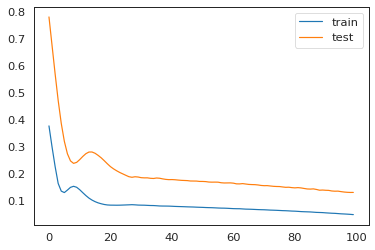

In [63]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Test

In [78]:
import math

# make a prediction
yhat = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X1[:, 1:]), axis=1)
print(inv_yhat.shape)
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X1[:, 1:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(63, 19)
Test MSE: 0.024
Test RMSE: 0.154


In [80]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
print('median_absolute_error', median_absolute_error(inv_y, inv_yhat))
print('mean_absolute_error', mean_absolute_error(inv_y, inv_yhat))

median_absolute_error 0.11782092
mean_absolute_error 0.13060144
